In [1]:
import os
os.environ["GOWINHOME"] = "/home/pepijn/bin/gowin"
os.environ["DEVICE"] = "GW1N-1"
from apycula import tiled_fuzzer
from apycula import codegen
from apycula import pindef
from apycula import bslib
from apycula import chipdb
from apycula import fuse_h4x
from apycula import gowin_unpack
from apycula.wirenames import wirenames
from PIL import Image
import numpy as np
import pickle
import json

# a semi-dual-port bram as generated by the vendor

#   SDPB memory_ins130 (
#     .DI({GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,GND,data_in_33,data_in_31,data_in_29,data_in_27,data_in_25,data_in_23,data_in_21,data_in_19,data_in_17,data_in_15,data_in_13,data_in_11,data_in_9,data_in_7,data_in_5,data_in_3}),
#     .BLKSELA({GND,GND,GND}),
#     .BLKSELB({GND,GND,GND}),
#     .ADA({GND,GND,wr_addr_17,wr_addr_15,wr_addr_13,wr_addr_11,wr_addr_9,wr_addr_7,wr_addr_5,wr_addr_3,GND,GND,VCC,VCC}),
#     .ADB({GND,GND,rd_addr_17,rd_addr_15,rd_addr_13,rd_addr_11,rd_addr_9,rd_addr_7,rd_addr_5,rd_addr_3,GND,GND,GND,GND}),
#     .CLKA(clk_3),
#     .CLKB(clk_3),
#     .CEA(wr_en_3),
#     .CEB(rd_en_3),
#     .OCE(GND),
#     .RESETA(GND),
#     .RESETB(GND),
#     .DO({memory_6_DO31,memory_6_DO30,memory_6_DO29,memory_6_DO28,memory_6_DO27,memory_6_DO26,memory_6_DO25,memory_6_DO24,memory_6_DO23,memory_6_DO22,memory_6_DO21,memory_6_DO20,memory_6_DO19,memory_6_DO18,memory_6_DO17,memory_6_DO16,\data_out[15]_8 ,\data_out[14]_8 ,\data_out[13]_8 ,\data_out[12]_8 ,\data_out[11]_8 ,\data_out[10]_8 ,\data_out[9]_8 ,\data_out[8]_8 ,\data_out[7]_8 ,\data_out[6]_8 ,\data_out[5]_8 ,\data_out[4]_8 ,\data_out[3]_8 ,\data_out[2]_8 ,\data_out[1]_8 ,\data_out[0]_9 }) 
# );
# defparam memory_ins130.BIT_WIDTH_0=16;
# defparam memory_ins130.BIT_WIDTH_1=16;
# defparam memory_ins130.READ_MODE=1'b0;
# defparam memory_ins130.RESET_MODE="SYNC";

def bram(mod, cst, row, idx, readmode=False, bits0=4, bits1=4, reset=True):
    "make a bram"
    name = tiled_fuzzer.make_name("SDPB", "SDPB")
    bram = codegen.Primitive("SDPB", name)
    bram.portmap['DI'] = tuple(f"{name}_DI{i}" for i in range(32))
    bram.portmap['BLKSELA'] = tuple(f"{name}_BLKSELA{i}" for i in range(3))
    bram.portmap['BLKSELB'] = tuple(f"{name}_BLKSELB{i}" for i in range(3))
    bram.portmap['ADA'] = tuple(f"{name}_ADA{i}" for i in range(14))
    bram.portmap['ADB'] = tuple(f"{name}_ADB{i}" for i in range(14))
    bram.portmap['DO'] = tuple(f"{name}_DO{i}" for i in range(32))
    bram.portmap['CLKA'] = name+"_CLKA"
    bram.portmap['CLKB'] = name+"_CLKB"
    bram.portmap['CEA'] = name+"_CEA"
    bram.portmap['CEB'] = name+"_CEB"
    bram.portmap['OCE'] = name+"_OCE"
    bram.portmap['RESETA'] = name+"_RESETA"
    bram.portmap['RESETB'] = name+"_RESETB"
    bram.params["READ_MODE"] = "1'b0" if readmode else "1'b1"
    bram.params["BIT_WIDTH_0"] = str(2**bits0)
    bram.params["BIT_WIDTH_1"] = str(2**bits1)
    bram.params["RESET_MODE"] = "\"SYNC\"" if reset else "\"ASYNC\""
    mod.wires.update(bram.portmap.values())
    mod.primitives[name] = bram
    cst.cells[name] = f"BSRAM_R{row}[{idx}]"
    return bram.portmap

with open(f"{tiled_fuzzer.gowinhome}/IDE/share/device/{tiled_fuzzer.device}/{tiled_fuzzer.device}.fse", 'rb') as f:
    fse = fuse_h4x.readFse(f)
    
with open(f"apycula/{tiled_fuzzer.device}.pickle", 'rb') as f:
    db = pickle.load(f)

with open(f"{tiled_fuzzer.device}.json") as f:
    dat = json.load(f)


check 19199191


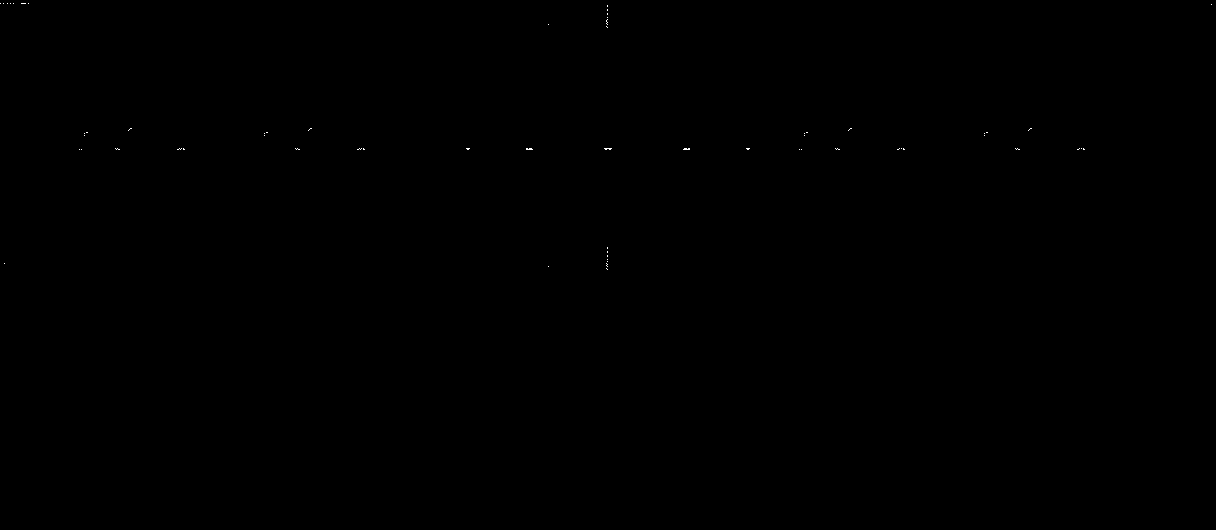

In [8]:
# pipe cleaning, can we generate a BRAM without the vendor tools yelling at us?
mod = codegen.Module()
cst = codegen.Constraints()

# brams = [bram(mod, cst, row, col) for row, col in [(6, 1), (6, 2), (6, 0), (6, 3)]]

bram(mod, cst, 6, 0, readmode=False, reset=False)
bram(mod, cst, 6, 1, readmode=True, reset=False)
bram(mod, cst, 6, 2, readmode=False, reset=True)
bram(mod, cst, 6, 3, readmode=True, reset=True)
# import io
# f = io.StringIO()
# mod.write(f)
# print(f.getvalue())

res = tiled_fuzzer.run_pnr(mod, cst, {})
bslib.display(None, res.bitmap)

In [3]:
# these are the dat file entries related to Bsram.
# in the case of IOB these were a trivial portmap.
inputs = [wirenames[n] for n in dat["BsramIn"]]
outputs = [wirenames[n] for n in dat["BsramOut"]]
inputsdlt = dat["BsramInDlt"]
outputsdlt = dat["BsramOutDlt"]

inputs = [f"{w}:{t}" for t, w in zip(inputs, inputsdlt)]
output = [f"{w}:{t}" for t, w in zip(outputs, outputsdlt)]
# these appear to be control signals of some sort. Weird that they repeat.
ctl = inputs[:18]
# Maybe which of the 3 tiles the wire is in
# Every BRAM seems to take up 3 tiles, so the numbers make sense
print(len(ctl))
print(ctl)
# these seems to kinda line up
# But still two CLK0 in tile 0, which doesn't make a lot of sense
print(ctl[0::5], ctl[1::5], ctl[2::5], ctl[3::5], ctl[4::5])
print(ctl[:5]) # this seems to repeat 3 times
print(ctl[-3:]) # these 3 are special
# It'd make sense if
# CLKA/CLKB => CLK0
# RESETA/RESETB => LSR0/LSR1
# CEA/CEB/OCE => CE0/CE1
# BLKSELA/BLKSELB??? (3 bits each)

# these appear to be the "normal" inputs, I'm guessing the address and data lines
# .DI .ADA .ADB .DO
# .D[I0] = 32 bits
# .AD[AB] = 14 bits
# not sure how this makes sense
no = 2*32+2*14+4*3 # inputs
addr = inputs[18:]
l = len(addr)
# how many inputs are there? Does this make sense with the inputs we know about?
print(l, no, l - no)
# Hmmm the numbers don't really seem to add up
print(addr)
# hmmm how many duplicates are there?
print(len(addr)-len(set(addr)))
# well that's also not a logical number
# I'm guessing some random ports just need to be connected to all 3 tiles?
# Maybe I'll just need to fuzz which wire seems to go where.
# Hook up one wire, unpack and inspect the routing muxes, see what matches what.
# ECP5 is fairly similar as usual: http://yosyshq.net/prjtrellis-db/ECP5/tilehtml/MIB_EBR0.html

18
['0:CLK0', '0:CE0', '0:CE1', '0:LSR0', '0:LSR1', '1:CLK0', '1:CE0', '1:CE1', '1:LSR0', '1:LSR1', '0:CLK0', '0:CE0', '0:CE1', '0:LSR0', '0:LSR1', '0:CE2', '0:LSR2', '2:CE0']
['0:CLK0', '1:CLK0', '0:CLK0', '0:CE2'] ['0:CE0', '1:CE0', '0:CE0', '0:LSR2'] ['0:CE1', '1:CE1', '0:CE1', '2:CE0'] ['0:LSR0', '1:LSR0', '0:LSR0'] ['0:LSR1', '1:LSR1', '0:LSR1']
['0:CLK0', '0:CE0', '0:CE1', '0:LSR0', '0:LSR1']
['0:CE2', '0:LSR2', '2:CE0']
114 104 10
['1:C4', '1:C5', '1:C6', '1:C7', '1:C0', '1:C1', '0:C0', '0:C1', '0:C2', '0:C3', '0:C4', '0:C5', '1:C2', '1:C3', '1:C4', '1:C5', '1:C6', '1:C7', '1:C0', '1:C1', '0:C0', '0:C1', '0:C2', '0:C3', '0:C4', '0:C5', '1:C2', '1:C3', '0:D0', '0:D1', '0:D2', '0:D3', '0:D4', '0:D5', '0:D6', '0:D7', '0:B6', '0:B7', '1:B0', '1:D0', '1:B1', '1:D1', '1:B2', '1:D2', '1:B3', '1:D3', '0:D0', '0:D1', '0:D2', '0:D3', '0:D4', '0:D5', '0:D6', '0:D7', '0:B6', '0:B7', '1:B0', '1:D0', '1:B1', '1:D1', '1:B2', '1:D2', '1:B3', '1:D3', '1:B4', '1:D4', '1:B5', '1:D5', '1:B6', '1:D6

In [4]:
from itertools import product

def coinsproblem(bounds, target):
    rv = []
    for x in product(*(range(target + 1) for y in bounds)):
        subtotal = sum([ai * bi for ai, bi in zip(x, bounds)])
        if subtotal == target:
            rv.append(x)
    rv.sort()
    return rv

# it seems there is no reasonable combination of address, data, and blksel that adds up to 114
print(coinsproblem([32, 14, 3], 114))

[(0, 0, 38), (0, 3, 24), (0, 6, 10), (1, 2, 18), (1, 5, 4), (2, 1, 12), (3, 0, 6)]


5 1 39


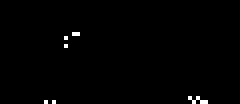

5 2 40


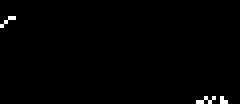

5 4 39


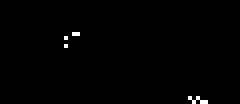

5 5 40


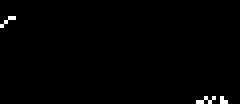

5 13 39


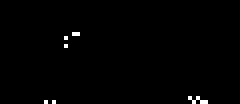

5 14 40


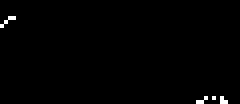

5 16 39


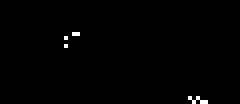

5 17 40


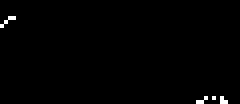

In [28]:
tiles = fuse_h4x.tile_bitmap(fse, res.bitmap)
tiles.keys()

for (row, col, ttyp), tile in tiles.items():
    im = bslib.display(None, tile)
    im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
    if row == 5 and ttyp < 50:
        print(row, col, ttyp)
        display(im_scaled)

In [27]:
# pretty sure these upper bits are just routing, which we can parse
# this seems just an elaborate way to set LSR1 to VSS=0?
print(gowin_unpack.parse_tile_(db, 5, 1, tiles[(5, 1, 39)], default=False)[1])
print(gowin_unpack.parse_tile_(db, 5, 2, tiles[(5, 2, 40)], default=False)[1])
# well that's because LSR1 doesn't have VSS as an input itself, so okay
db.grid[5][2].pips["LSR1"]

(5, 1)
{'E210': 'VSS'}
(5, 2)
{'LSR1': 'E211'}


{'VCC': set(),
 'LB31': {(4, 3), (6, 0)},
 'W212': {(4, 3), (6, 1)},
 'N272': {(4, 3), (6, 2)},
 'X05': {(4, 2), (6, 4)},
 'X06': {(4, 2), (4, 3), (6, 0), (6, 4)},
 'X07': {(4, 2), (4, 3), (6, 1), (6, 4)},
 'X08': {(4, 2), (4, 3), (6, 2), (6, 4)},
 'N271': {(4, 2), (4, 3), (6, 1), (7, 0)},
 'S271': {(4, 2), (4, 3), (5, 1), (6, 2)},
 'E211': {(4, 2), (4, 3), (5, 1), (6, 0)},
 'E271': {(4, 2), (4, 3), (5, 1), (6, 1)},
 'W211': {(4, 2), (4, 3), (6, 0), (7, 0)},
 'S272': {(4, 2), (4, 3), (6, 2), (7, 2)},
 'E212': {(4, 2), (4, 3), (6, 0), (7, 2)},
 'E272': {(4, 2), (4, 3), (6, 1), (7, 2)},
 'LB01': {(4, 2), (5, 1)},
 'LB11': {(4, 2), (7, 2)},
 'LB21': {(4, 2), (7, 0)},
 'LB71': {(4, 2), (4, 3), (6, 2), (7, 0)}}

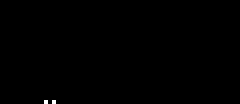

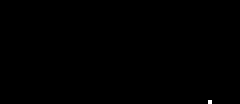

In [32]:
# so these two bits are responsible for read mode
t = tiles[(5, 1, 39)] ^ tiles[(5, 4, 39)]
im = bslib.display(None, t)
im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
display(im_scaled)

# and this one bit is for the reset mode
t = tiles[(5, 2, 40)] ^ tiles[(5, 14, 40)]
im = bslib.display(None, t)
im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
display(im_scaled)

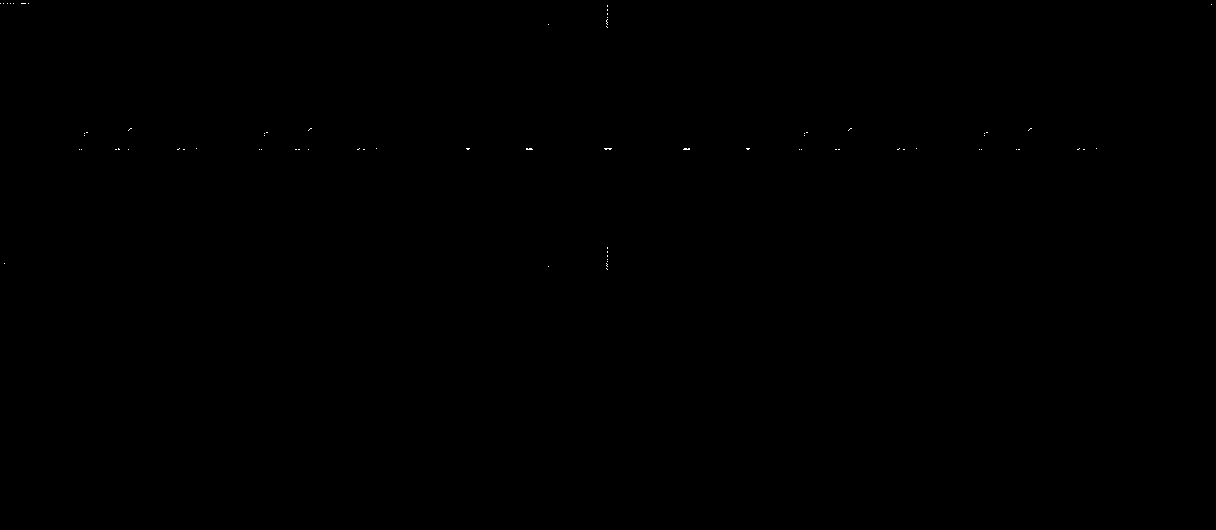

In [35]:
mod = codegen.Module()
cst = codegen.Constraints()

# let's run a few bit widths to see what happens
bram(mod, cst, 6, 0, bits0=0)
bram(mod, cst, 6, 1, bits0=1)
bram(mod, cst, 6, 2, bits0=2)
bram(mod, cst, 6, 2, bits0=3)

res = tiled_fuzzer.run_pnr(mod, cst, {})
tiles = fuse_h4x.tile_bitmap(fse, res.bitmap)
bslib.display(None, res.bitmap)

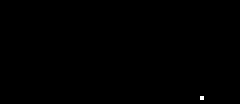

In [40]:
t = tiles[(5, 1, 39)] ^ tiles[(5, 13, 39)]
im = bslib.display(None, t)
im_scaled = im.resize((im.width*4, im.height*4), Image.NEAREST)
display(im_scaled)